In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.MAF import MAF
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

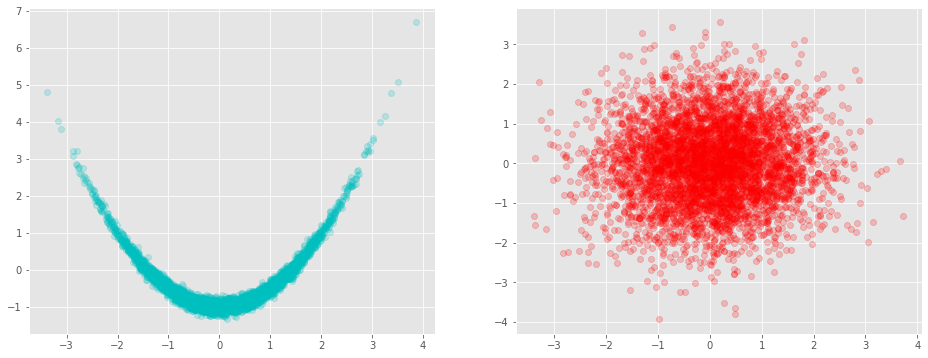

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0, start_height = -1)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
maf = MAF(num_layers=4, neuron_list=[50,50])

# Create optimizer and compile maf with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
maf.compile(opt)

# Perform a forward pass to initialize variables
_ = maf(latent)

In [4]:
# Define training options
n_epochs = 150
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
maf.batch_norm_mode(True)
history = maf.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
maf.batch_norm_mode(False)

Epoch 1/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 5.7443
Epoch 2/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 3.9217
Epoch 3/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 3.1743
Epoch 4/150
100/100 [==============================] - 0s 5ms/step - Negative Log Likelihood: 2.7879
Epoch 5/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 2.4628
Epoch 6/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 2.2233
Epoch 7/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 2.0307
Epoch 8/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 1.8663
Epoch 9/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 1.7278
Epoch 10/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likeliho

100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 0.6518
Epoch 82/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6436
Epoch 83/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6679
Epoch 84/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6607
Epoch 85/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6494
Epoch 86/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6688
Epoch 87/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6500
Epoch 88/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6474
Epoch 89/150
100/100 [==============================] - 1s 5ms/step - Negative Log Likelihood: 0.6602
Epoch 90/150
100/100 [==============================] - 1s 6ms/step - Negative Log Likelihood: 

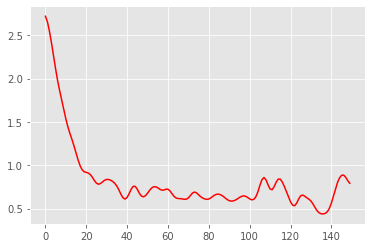

In [5]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(ysmoothed, color = 'r')

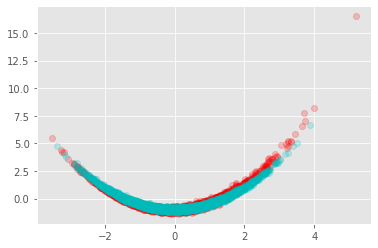

In [6]:
# Plot to make sure it worked
forward_pass = maf(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Conditional Sampling using Metropolis Hastings

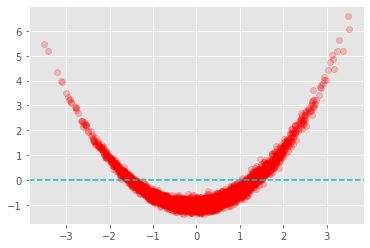

In [7]:
# We want to draw conditional samples from about y = 0.0
y_star = 0.0

forward_pass = maf(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [ ]:
# Run the algorithm
acc_rate, samples = MH2d(maf, y_star = 0.0)
print(acc_rate)

it: 0 time: 0.9145374298095703
it: 1000 time: 2.1551239490509033
it: 2000 time: 2.048595428466797
it: 3000 time: 2.194891929626465
it: 4000 time: 2.0633909702301025


In [ ]:
# Plot the conditional samples
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples, 150, (-5, 5), color='r', alpha=.8, density=True, zorder=10)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-3, 3))